## 3-1. 협업 필터링의 원리

협업 필터링(CF: Collaborative Filtering) : 어떤 아이템에 대해서 비슷한 취향을 가진 사람들은 다른 아이템에 대해서도 비슷한 취향을 가지고 있을 것이라 가정하여, 취향을 기준으로 추천하는 알고리즘  

1. A와 취향이 비슷한 사용자(neighbor)를 찾자. 즉, 사용자 간 유사도가 높은 사용자를 찾자. (e.g. 영화에 대한 평가의 유사성 계산)
2. 취향이 비슷한 사용자들이 공통적으로 좋아하는 제품을 찾자. (e.g. 취향이 비슷한 사용자들이 좋게 평가한 영화를 찾기)
3. 공통적으로 좋아한 제품을 A에게 추천하자.

## 3-2. 유사도지표

CF에서는 사용자들의 평가를 기반으로 사용자 간 유사도를 구하는 것이 핵심이다.  
CF에서는 다양한 사용자 간의 유사도 지(similarity index)를 사용할 수 있는데, 이 중에서 중요한 유사도지표에 대해서 아래에 설명한다.

1. 상관계수 (correlation coefficient)  
- 평가 자료가 연속값인 경우, 가장 이해하기 쉬운 유사도   

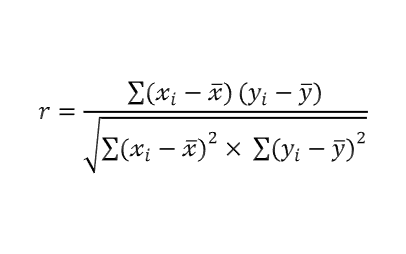  
- x, y: 유사도의 계산 대상이 되는 두 사용자
- xi, yi: 두 사용자가 공통으로 평가한 아이템 중에서 i번째 아이템에 대한 이 두 사용자의 평가 값
- 상관계수는 최소 -1(완전 반대)에서 최대 1(완전 일치)까지의 값을 가짐

2. 코사인 유사도 (cosine similarity)  
- 평가 자료가 연속값인 경우, CF에서 가장 널리 쓰이는 유사도  

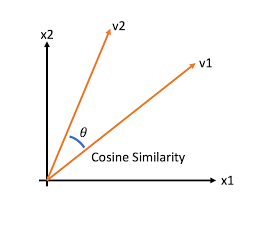
- 각 아이템을 하나의 차원으로 보고, 사용자의 평가값을 좌표 값으로 봄
- 각 사용자의 평가값을 벡터로 표현 가능
- 두 사용자의 평가값이 유사할수록 각도가 작아지기에 코사인값이 커짐  

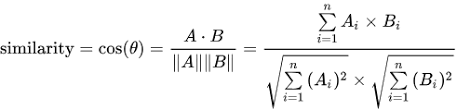
- A, B: 유사도 대상이 되는 두 사용자이고
- Ai, Bi: 두 사용자가 공통적으로 평가한 아이템 중 i번째 아이템에 대한 평가 값


3. 타니모토 계수 (Tanimoto coefficient)  

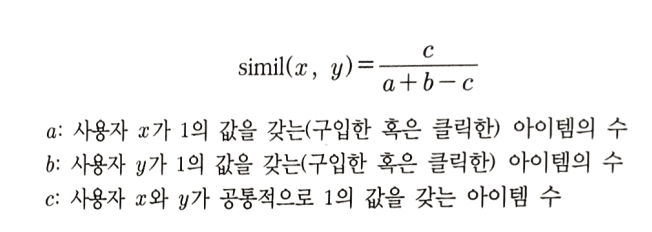  

- 평가 자료가 이진값인 경우 널리 사용되는 유사도  
- 이진수 데이터에 대해서 CF에서 상당히 좋은 결과를 보여줌
- 최소 0 (완전 불일치) ~ 최대 1 (완전 일치)
- 타니모토 계수의 변형으로 자카드 계수가 있음


## 3-3. 기본 CF 알고리즘

가장 기본적인 CF 알고리즘은 위에서 설명한 것 중에서 이웃을 전체 사용자로 한다. 즉, 현재 사용자와 취향이 비슷한 사용자 그룹을 따로 선정하지 않고 모든 사용자의 평점을 가지고 예측을 한다. 
1. 모든 사용자 간의 평가의 유사도를 계산
2. 현재 추천 대상이 되는 사람과 다른 사용자의 유사도를 추출
3. 현재 사용자가 평가하지 않은 모든 아이템에 대해 현재 사용자의 예상 평가값을 구함  
    (예상 평가값: 다른 사용자의 해당 아이템에 대한 평가를 현재 사용자와 그 사용자와의 유사도로 가중해서 평균을 낸 값)
4. 아이템 중 예상 평가값이 가장 높은 N개의 아이템을 추천

In [26]:
# Created or modified on May 2022
# Author: 임일
# 협업필터링(CF) 추천 - 기본

################# 앞 장 동일: 데이터 읽어오기, RMSE 계산, full matrix로 변환
import numpy as np
import pandas as pd

# 데이터 읽어 오기 
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../Data/u.user', sep='|', names=u_cols, encoding='latin-1')
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 'unknown', 
        'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
        'Thriller', 'War', 'Western']
movies = pd.read_csv('../Data/u.item', sep='|', names=i_cols, encoding='latin-1')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../Data/u.data', sep='\t', names=r_cols, encoding='latin-1')

# timestamp 제거 
ratings = ratings.drop('timestamp', axis=1)
# movie ID와 title 빼고 다른 데이터 제거
movies = movies[['movie_id', 'title']]

# train, test 데이터 분리
from sklearn.model_selection import train_test_split
x = ratings.copy()
y = ratings['user_id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

# 정확도(RMSE)를 계산하는 함수 
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# 모델별 RMSE를 계산하는 함수 
def score(model):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

# train 데이터로 Full matrix 구하기 
rating_matrix = x_train.pivot(index='user_id', columns='movie_id', values='rating')

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [28]:

################# 코사인 유사도로 유사도 계산하여 추천

from sklearn.metrics.pairwise import cosine_similarity  # 코사인 유사도를 구하기 위해 import
matrix_dummy = rating_matrix.copy().fillna(0)
# 1. 모든 사용자 간의 코사인 유사도를 구함
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)


def CF_simple(user_id, movie_id):   # '해당 user의 해당 movie에 대한 예상 평점'을 계산(가중평균)해서 돌려주는 함수
    if movie_id in rating_matrix:   # 해당 movie를 rating한 데이터가 훈련데이터에 있다면
        # 2. 현재 사용자와 다른 사용자 간의 similarity 가져오기
        sim_scores = user_similarity[user_id].copy()
        # 현재 영화에 대한 모든 사용자의 rating값 가져오기
        movie_ratings = rating_matrix[movie_id].copy()
        # 현재 영화를 평가하지 않은 사용자의 index 가져오기
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        # 현재 영화를 평가하지 않은 사용자의 rating (null) 제거
        movie_ratings = movie_ratings.dropna()
        # 현재 영화를 평가하지 않은 사용자의 similarity값 제거
        sim_scores = sim_scores.drop(none_rating_idx)
        # 3. 현재 영화를 평가한 모든 사용자의 가중평균값 구하기
        mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
    else:
        mean_rating = 3.0
    return mean_rating

# 예측 정확도 계산
score(CF_simple)

1.0223182916665117

RMSE가 약 1.022로서 성별이나 직업별 평균을 사용한 경우보다 상당히 개선되었음을 알 수 있음.  
즉 평가경향이 비슷한(유사도가 높은) 사용자에게 가중치를 더 주어서 평균을 계산하면 더 정확한 예측을 할 수 있음.